In [124]:
#### UPDATE TO USE PLAYER WIN %

# Correlation with Team Performance
In this notebook, I will analyze the correlation between the chosen categories and team performance. The purpose is to better understand the value of the predictions that will be made.

Goals:
- Create the expected value and rates for each play type for each player.
- Gain insights into the value of the categories that will be predicted.

Conclusions and Results:  
- A few years had to be removed from the master data frame due to null values in the features required to make EV and Rates.
- Expected values were all correlated with better offensive ratings and were significantly less correlated with defensive ratings. It will be important to remember that these stats are unrelated to defensive performance.
- Rates were much less correlated with ORTG and pull-up rate had the highest. Therefore, knowing how often a player does something is less valuable than knowing how well they do it.
- Post-ups EV was the only category to have a negative correlation with DRTG (which is good). This could be because post-ups is related to other information like height which might influence rebounding and defense.
- All EVs have a similar relatively low correlation with win percentage.
- Still, ORTG was 1.5 times more correlated than DRTG with win percentage. So, knowing a player's offensive production is likely more valuable than knowing their defensive production.

Extra Insights:
- Driving rates and pull-up rates are very highly correlated (.7). When modeling, using similar predictive features may work well.
- For shooting categories rates and EV with relatively highly correlated. Similarly, using similar predictive features may work well.

## Importing Libraries and Data

In [339]:
# Importing libraries and scripts
import pandas as pd
from dictionaries import team_map
from df_functions import add_season
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [340]:
# Loading datasets
master_df = pd.read_csv('./data/master_df', index_col=0)
standings = pd.read_csv('./data/standings', index_col=0)
league_assists = pd.read_csv('./data/assists_value', index_col=0)
league_turnovers = pd.read_csv('./data/turnovers', index_col=0)
team_advanced = pd.read_csv('./data/team_advanced', index_col=0)

## Creating Points Per Possession
### Calculating Points Per Assist (Expected Value of an Assist)

$ \dfrac{\text{3FGM}_{AST}}{\text{FGA}} = \text{3FG%} * \text{3FGA%} * \text{3FG}_{\%AST} $ 

In [341]:
# Saving assisted 3s rates
assisted_3 = league_assists['3P.1'] * league_assists['3P'] * league_assists['%Ast\'d.1']

In [342]:
# Looking at the trends in assisted 3 pointers
assisted_3

2018    0.101255
2017    0.094462
2016    0.084344
2015    0.079073
2014    0.078042
2013    0.074239
2012    0.066491
2011    0.068349
dtype: float64

$ \dfrac{\text{2FGM}_{AST}}{\text{FGA}} = \text{2FG%} * \text{2FGA%} * \text{2FG}_{\%AST} $  

In [343]:
# Saving assisted 2s rates
assisted_2 = league_assists['2P.1'] * league_assists['2P'] * league_assists['%Ast\'d']

In [344]:
# Looking at the trends in assisted 2 pointers
assisted_2

2018    0.168727
2017    0.170306
2016    0.179043
2015    0.184610
2014    0.187313
2013    0.195613
2012    0.191245
2011    0.196263
dtype: float64

$ \dfrac{\text{FGM}_{AST}}{\text{FGA}} = \dfrac{\text{3FGM}_{AST}}{\text{FGA}} + \dfrac{\text{2FGM}_{AST}}{\text{FGA}}$  

In [345]:
# Saving assist rates
assisted_fg = assisted_2 + assisted_3

$ EV(\text{AST}) = \dfrac{\text{3FGM}_{AST} * 3 + \text{2FGM}_{AST} * 2}{\text{FGM}_{AST}} = \dfrac{\frac{\text{3FGM}_{\text{AST}}}{\text{FGA}} * 3 + \frac{\text{2FGM}_{\text{AST}}}{\text{FGA}} * 2}{\frac{\text{FGM}_{\text{AST}}}{\text{FGA}}}$  

In [346]:
# Saving the value of an assist for each year
assist_value = (assisted_3 * 3 + assisted_2 * 2) / assisted_fg

In [347]:
# Looking at trends in the value of an assist
assist_value

2018    2.375044
2017    2.356773
2016    2.320228
2015    2.299880
2014    2.294104
2013    2.275110
2012    2.257981
2011    2.258300
dtype: float64

### Calculating Points Per Turnover (Expected Value of a Turnover)

$ EV(\text{TO}) = \dfrac{\sum{PTS_{TO}}}{\sum{TO}} $

In [348]:
# Saving the value of a turnover
turnover_value = league_turnovers['PTS_OFF_TOV'] / league_turnovers['TOV']

In [349]:
# Looking at trends in the value of turnovers
turnover_value

2018    1.153810
2017    1.154011
2016    1.132762
2015    1.126335
2014    1.136581
2013    1.139061
2012    1.122258
2011    1.137810
dtype: float64

### Creating Points Per Play
#### Dropping Years with NANs

In [350]:
master_df = master_df[master_df['SEASON'].isin(range(2014, 2019))].reset_index(drop=True)

#### Shooting Plays

$ EV(FGA) = \text{EFG%} * 2  $  

$ FGA_{rate} = \dfrac{FGA}{MIN} $

In [351]:
# Calculating the expected value (in points) and rate of shooting plays
master_df['CATCH_SHOOT_EV'] = master_df['CATCH_SHOOT_EFG_PCT'] * 2
master_df['CATCH_SHOOT_RATE'] = master_df['CATCH_SHOOT_FGA'] / master_df['MIN']
master_df['PULL_UP_EV'] = master_df['PULL_UP_EFG_PCT'] * 2
master_df['PULL_UP_RATE'] = master_df['PULL_UP_FGA'] / master_df['MIN']

#### Drives and Post-Ups

In [352]:
# Function for mapping points from a category (assists, TO, etc.) to individual players
def pts_generated(series, values, play, category):
    
    # Calculating the points from the category using the value of that category in that season
    season = series['SEASON']
    points = values[season] * series[play + '_' + category]
    
    return points

$ EV(\text{PLAY}) = \dfrac{\text{PTS}_{play} + \text{AST}_{play} * EV(\text{AST}) - \text{TO}_{play} * EV(\text{TO})}{(\text{FGA}_{play} + \text{FTA}_{play} - \text{PF}_{play}) + \text{AST}_{play} * \frac{\text{AST}_{potential}}{\text{AST}} + \text{TO}_{play}}$  
<br>
<br>
$ PLAY_{rate} = \dfrac{(\text{FGA}_{play} + \text{FTA}_{play} - \text{PF}_{play}) + \text{AST}_{play} * \frac{\text{AST}_{potential}}{\text{AST}} + \text{TO}_{play}}{MIN}$

This was a situation where I had to decide between using a player's assist to potential assist ratio versus the league ratio. Players on teams with poor shooting will be undervalued, but quality of player passes will be valued.

<sub>* These are significantly more complicated because there are many more ways for the play to end.</sub>

In [353]:
# Calculating the points earned from driving
drive_assist_points = master_df.apply(pts_generated, values=assist_value, play='DRIVE', category='AST', axis=1)
drive_turnover_points = master_df.apply(pts_generated, values=turnover_value, play='DRIVE', category='TOV', axis=1)
drive_total_points = master_df['DRIVE_PTS'] + drive_assist_points - drive_turnover_points

In [354]:
# Calculating the number of possessions used by drives
drive_shots = master_df['DRIVE_FGA'] + master_df['DRIVE_FTA'] - master_df['DRIVE_PF']
drive_potential_assists = master_df['DRIVE_AST'] * master_df['POTENTIAL_AST'] / master_df['AST']
drive_potential_assists.fillna(0, inplace=True)
drive_possessions = drive_shots + drive_potential_assists + master_df['DRIVE_TOV']

In [355]:
# Calculating the expected value and rate of drives
master_df['DRIVE_EV'] = drive_total_points/drive_possessions
master_df['DRIVE_EV'].replace(np.infty, np.nan, inplace=True)
master_df['DRIVE_RATE'] = drive_possessions/master_df['MIN']

In [356]:
# Calculating the points earned by posting-up
post_assist_points = master_df.apply(pts_generated, values=assist_value, play='POST_TOUCH', category='AST', axis=1)
post_turnover_points = master_df.apply(pts_generated, values=turnover_value, play='POST_TOUCH', category='TOV', axis=1)
post_total_points = master_df['POST_TOUCH_PTS'] + post_assist_points - post_turnover_points

In [357]:
# Calculating the number of possessions used by post-ups
post_shots = master_df['POST_TOUCH_FGA'] + master_df['POST_TOUCH_FTA'] - master_df['POST_TOUCH_FOULS']
post_potential_assists = master_df['POST_TOUCH_AST'] * master_df['POTENTIAL_AST'] / master_df['AST']
post_potential_assists.fillna(0, inplace=True)
post_possessions = post_shots + post_potential_assists + master_df['POST_TOUCH_TOV']

In [358]:
# Calculating the expected value and rate of post-ups
master_df['POST_TOUCH_EV'] = post_total_points/post_possessions
master_df['POST_TOUCH_EV'].replace(np.infty, np.nan, inplace=True)
master_df['POST_TOUCH_RATE'] = post_possessions/master_df['MIN']

## Correlation
### Preparing to Graph

In [359]:
# Setting the variables to look for correlation between
targets = ['OFF_RATING', 'DEF_RATING', 'W_PCT']
features = [column for column in master_df.columns if '_EV' in column or '_RATE' in column]

### Graphs
#### Features to Targets
- Expected values were all correlated with better offensive ratings and were significantly less correlated with defensive ratings.
- Post-ups expected value had a slightly lower correlation than other EV categories with ORTG.
- Rates were much less correlated with ORTG and pull-up rate had the highest.
- Post-ups EV was the only category to have a negative correlation with DRTG (which is good).
- Categories had similar and relatively low correlations with wins.

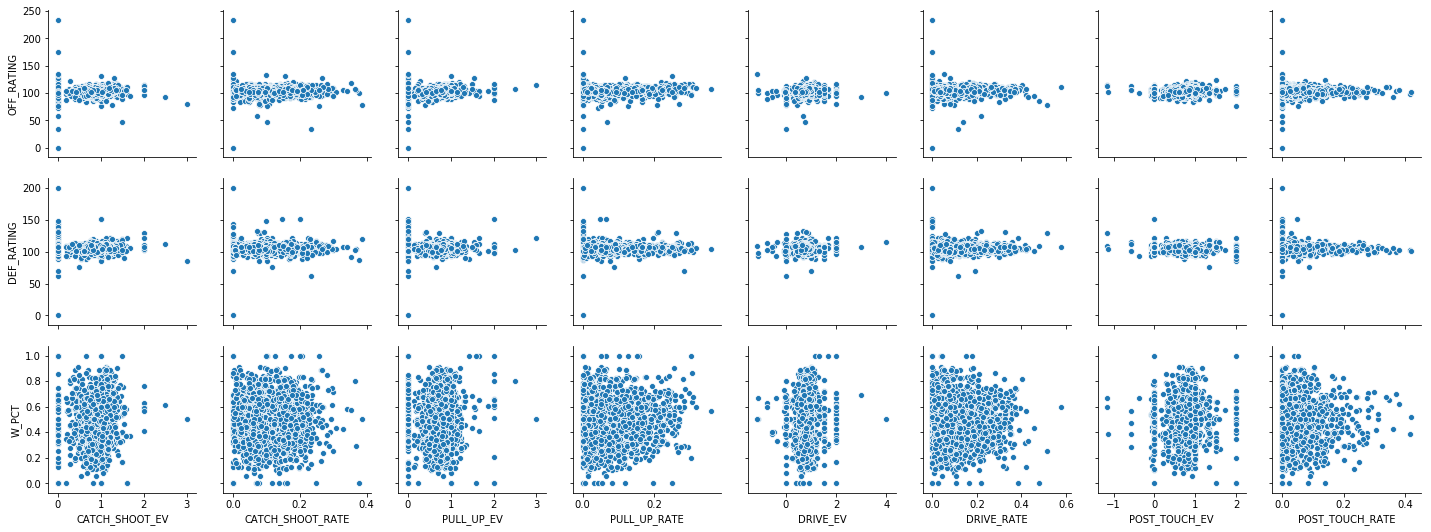

In [360]:
# Plotting scatter plots between the targets and features
sns.pairplot(master_df, x_vars=features, y_vars=targets);

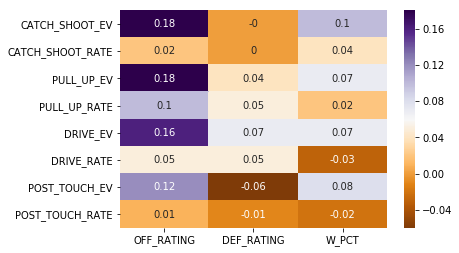

In [361]:
# Plotting the correlation to features to targets
sns.heatmap(master_df.corr().round(2).loc[features, targets], cmap='PuOr', annot=True)
plt.yticks(rotation=0);

#### Features to Features
- Post-up rate and drive rates had the highest negative correlation.
- Shooting categories EV had much higher correlations with their respective rates than driving and posting-up did.
- Drive rate and pull-up rate had the highest correlation (.7).
- Catch and shoot EV had a relatively strong correlation with pull-up shooting and rate and with driving rate.
- Drive rate was better correlated with catch and shoot EV and pull-up EV than with drive EV.
- Catch and shoot EV and rate were both relatively strongly correlated with pull-up EV, but only catch and shoot EV was relatively strongly correlated with pull-up rate.

/anaconda3/envs/dsi/lib/python3.6/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/envs/dsi/lib/python3.6/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


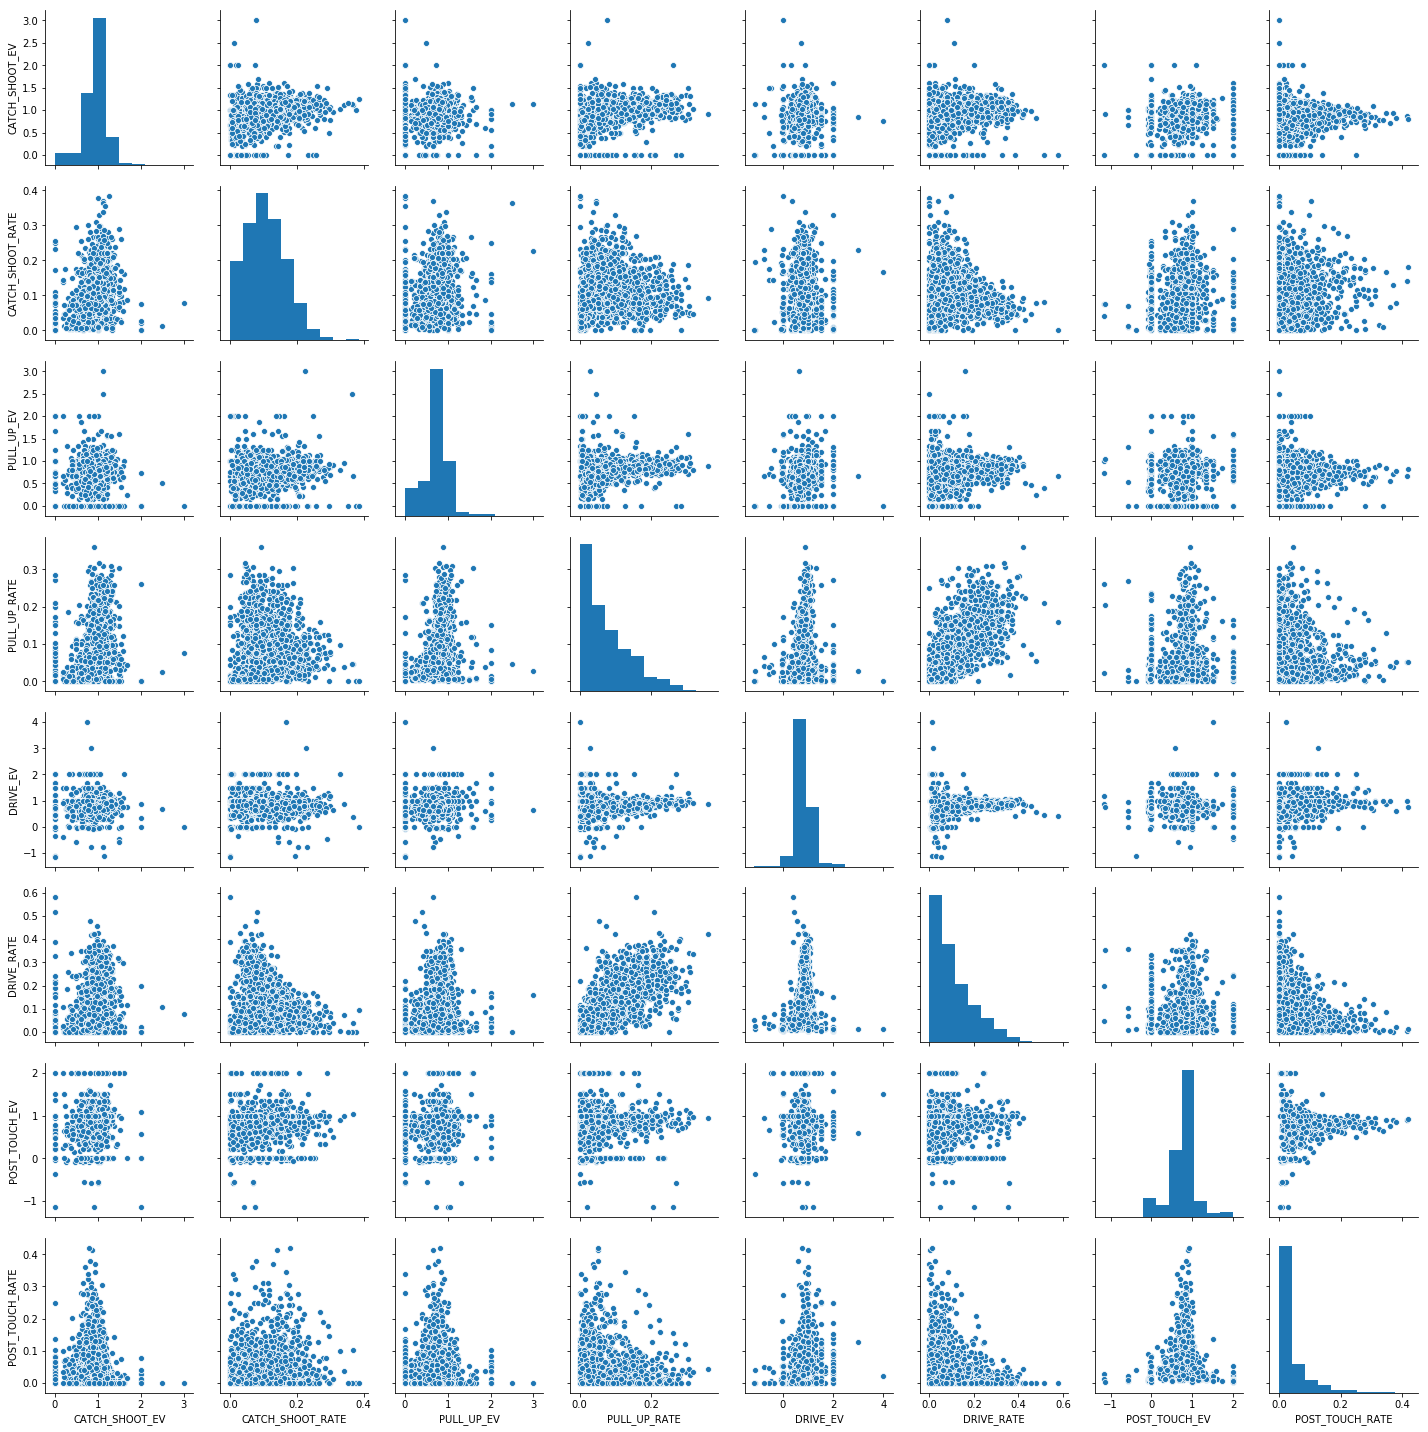

In [363]:
# Plotting scatter plots between the features and themselves
sns.pairplot(master_df, vars=features);

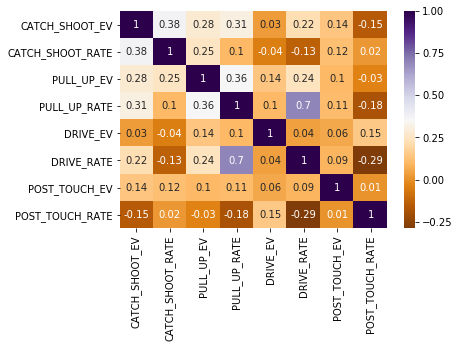

In [364]:
# Plotting the correlation to features to themselves
sns.heatmap(master_df.corr().round(2).loc[features, features], cmap='PuOr', annot=True)
plt.yticks(rotation=0);

#### Targets to Targets
- ORTG and DRTG are positively correlated (AKA teams with better offense generally have worse defense)
- ORTG and DRTG are similarly correlated with record

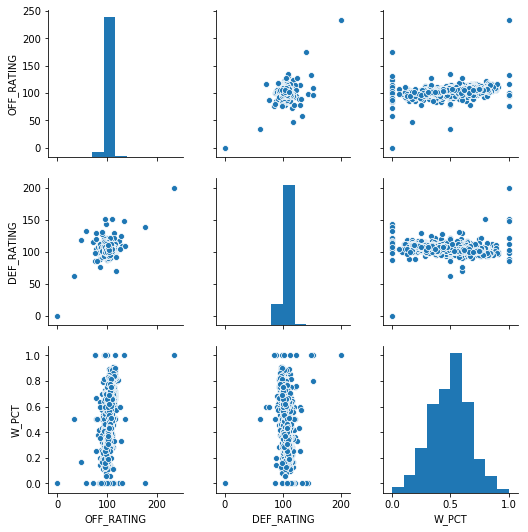

In [365]:
# Plotting scatter plots between the targets and themselves
sns.pairplot(master_df, vars=targets);

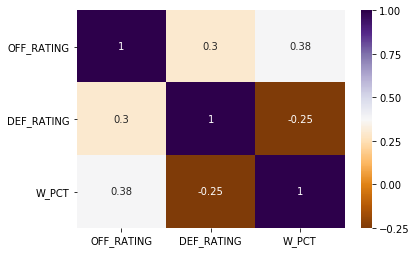

In [366]:
# Plotting the correlation to targets to themselves
sns.heatmap(master_df.corr().round(2).loc[targets, targets], cmap='PuOr', annot=True)
plt.yticks(rotation=0);

## Saving Data

In [367]:
# Saving the master data frame with the new features
master_df.to_csv('./data/master_df')